In [2]:
import os
import json
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
import csv

# Phase Extraction
from f_dacm import dacm
from f_noise_RM import remove_noise

from scipy.signal import butter, sosfiltfilt, filtfilt,lfilter


In [3]:
# Pembacaan Parameter Dataset
filename = "parameter.json"
with open(filename, 'r') as f:
    params = json.load(f)

In [4]:
# Function to read dataset.csv
def read_csv(filepath, row=True):
    df = pd.read_csv(filepath, header=None)
    if row: # row data
        data = df.T.values.tolist()[0]
    else: # comma-separated column data
        data = df.values.tolist()[0]
    return data
def read_raw(filepath):
    raw = []
    with open(filepath) as f:
        # read all lines into list of string
        lines = f.readlines()
        for line in lines:
            # remove leading and trailing white spaces and split by comma delimiter
            raw += line.strip().split(',')
    raw = [complex(s.replace('i', 'j')) for s in raw]
    return raw

In [5]:
dataset_folder = 'D:\Icen\Bimbingan TA\Read-Dataset-Publik-Radar-FMCW-\Children Dataset\Children Dataset'
radar_raw_folder = os.path.join(dataset_folder, "FMCW Radar\Rawdata")
radar_vital_folder = os.path.join(dataset_folder, "FMCW Radar\Heart Rate & Breathing Rate")
ref_raw_folder = os.path.join(dataset_folder, "Nihon Kohden\Heartbeat & Breathing Waveform")
ref_vital_folder = os.path.join(dataset_folder, "Nihon Kohden\Heart Rate & Breathing Rate")
subject_stats_folder = os.path.join(dataset_folder, "Participant\Human Data")
subject_photo_folder = os.path.join(dataset_folder, "Participant\Picture")

# Subject
subject_id = 7
radar_raw_path = os.path.join(radar_raw_folder, f"Rawdata_{subject_id}.csv")
raw_data = read_raw(radar_raw_path)## Pemanggilan Dataset Dari Folder 
# Merubah data list ke Array 
raw_data = np.asarray(raw_data, dtype=complex)
n_samples = raw_data.shape[0]//params['n_rx']
# print(raw_data.shape[0])
raw_radar = raw_data.reshape(params['n_rx'],n_samples, order='C')
raw_new = raw_radar.reshape((params['n_rx'],params['n_adc']*params['n_chirp'],-1), order='F')
#read heart rate (HR) and breath rate (BR) reading from reference device
ref_hr_path = os.path.join(ref_vital_folder, f"Ref_Heart_{subject_id}.csv")
ref_br_path = os.path.join(ref_vital_folder, f"Ref_Breath_{subject_id}.csv")
# Radar Paper
# read heart rate (HR) and breath rate (BR) estimation from radar
hr_radar_path = os.path.join(radar_vital_folder, f"Heart_{subject_id}.csv")
br_radar_path = os.path.join(radar_vital_folder, f"Breath_{subject_id}.csv")
#df_radar = pd.read_csv(hr_radar_path, header=None)
hr_radar = read_csv(hr_radar_path, row=True)
br_radar = read_csv(br_radar_path, row=True)
#df_hr = pd.read_csv(ref_hr_path, header=None)
hr = read_csv(ref_hr_path, row=False)
br = read_csv(ref_br_path, row=False)
# Waveform 
radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{subject_id}.csv")
radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{subject_id}.csv")
br_wave =np.array(read_csv(radar_br_wave_path))
hr_wave =np.array(read_csv(radar_hr_wave_path,row=True))

## Extract Target Signal to CSV

In [6]:
# for i in range(1, 51):
#     radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{i}.csv")
#     radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{i}.csv")
#     br_wave =np.array(read_csv(radar_br_wave_path)).reshape(1,-1)
#     hr_wave =np.array(read_csv(radar_hr_wave_path,row=True)).reshape(1,-1)
#     for j in range(4):
#         with open('br_wave.csv', 'a') as f: 
#             # Create a CSV writer object that will write to the file 'f'
#             csv_writer = csv.writer(f)
        
#             # Write all of the rows of data to the CSV file
#             csv_writer.writerows(br_wave)
#         with open('hr_wave.csv', 'a') as f: 
#             # Create a CSV writer object that will write to the file 'f'
#             csv_writer = csv.writer(f)
        
#             # Write all of the rows of data to the CSV file
#             csv_writer.writerows(hr_wave)

In [7]:
br_target = []
hr_target = []

with open('br_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        br_target.append(lines)
        
with open('hr_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        hr_target.append(lines)

In [8]:
br_target_array = []
hr_target_array = []
for i in range(0, 400, 2):
    br_target_array.append(br_target[i])
    hr_target_array.append(hr_target[i])
    
br_target_array = np.array(br_target_array).astype(np.int64)
hr_target_array = np.array(hr_target_array).astype(np.int64)

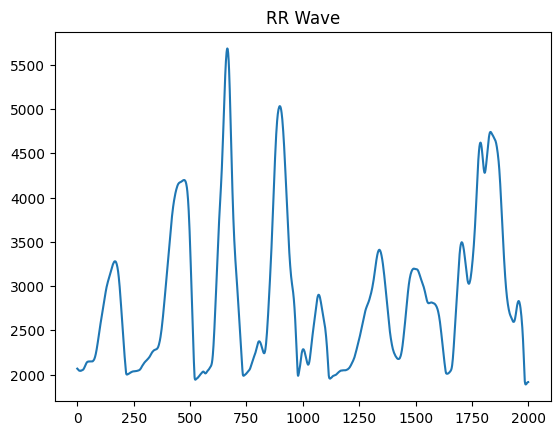

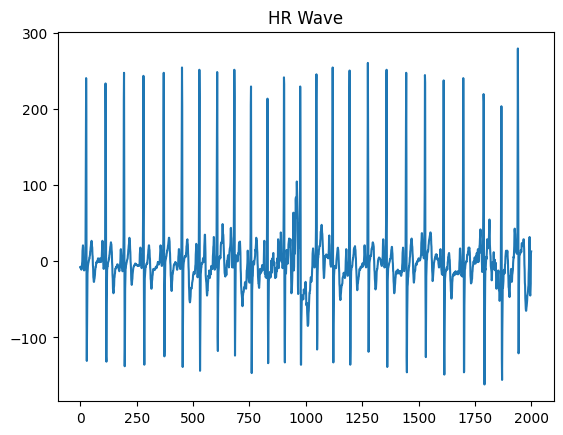

In [9]:
plt.figure(1)
plt.title("RR Wave")
plt.plot(br_target_array[0][:2000],label="RR Wave")
plt.figure(2)
plt.title("HR Wave")
plt.plot(hr_target_array[0][:2000],label="HR Wave")

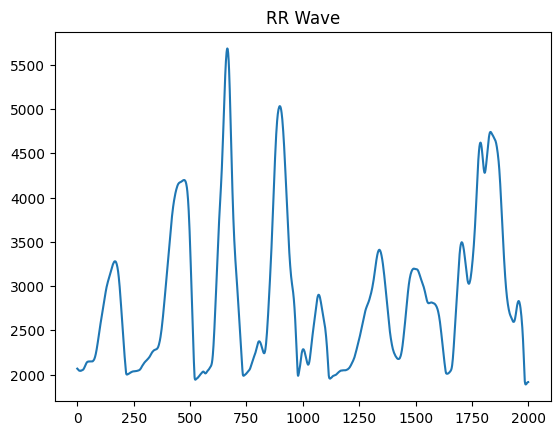

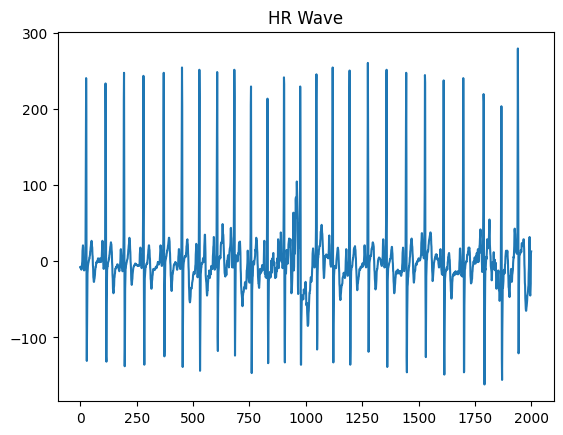

In [10]:
plt.figure(1)
plt.title("RR Wave")
plt.plot(br_target_array[0][:2000],label="RR Wave")
plt.figure(2)
plt.title("HR Wave")
plt.plot(hr_target_array[0][:2000],label="HR Wave")

## Extract Phase Signal to CSV

In [11]:
def Range_FFT(InputData):
    OutputData = np.zeros((params['n_rx'], params['n_fft'], params['data_len']), dtype=complex)
    dc_removal = np.zeros((params['n_rx'], params['n_fft']//2, params['data_len']), dtype=complex)
    for i in range(params['n_rx']):
        for j in range(params['data_len']):
            window = np.hamming(params['n_fft'])
            dc_removal[i,:,j]= InputData[i,:,j] - np.mean(InputData[i,:,j])
            OutputData[i,:,j]= fft((dc_removal[i,:,j]), n=1024)
    return OutputData

def MTI(hasil_fft):
    clutter = np.zeros((hasil_fft.shape[0], params['n_fft'], hasil_fft.shape[-1]),dtype=complex)
    OutputData = np.zeros((hasil_fft.shape[0],params['n_fft']//2, hasil_fft.shape[-1]),dtype=complex)
    alpha = 0.01
    for i in np.arange(hasil_fft.shape[0]):
        for j in np.arange(1,hasil_fft.shape[-1]):
            clutter[i,:,j] = np.dot(alpha,hasil_fft[i,:,j])+ np.dot((1-alpha),clutter[i,:,j-1])
            OutputData[i,:,j] = hasil_fft[i,np.arange(params['n_fft']//2),j]-(clutter[i,range(0, params['n_fft']//2),j])
    return OutputData

# Map Lokasinya 
def map_loc(data_mti):
    Range_Map_An1 = []
    index_max = []
    for i in range(1, params['data_len']):
        # Input data From MTI each Antenna 
        awal_an1 = data_mti[:, i] 
        abs_mti_1 = abs(awal_an1)
        peak_loc_an1 = np.argmax(abs_mti_1[25:60]) #pilih batas jarak
        rslt_peak_1 = 25 + peak_loc_an1
        if i > 1 and abs(rslt_peak_1 - index_max[-1]) == 10:
            # Jika perbedaan adalah 10, pilih peak tertinggi kedua
            abs_mti_1[peak_loc_an1] = 0  # Hilangkan peak pertama
            peak_loc_an1 = np.argmax(abs_mti_1[25:60])
            rslt_peak_1 = 25 + peak_loc_an1
        map_loc_an1 = awal_an1[rslt_peak_1]
        index_max.append(abs(rslt_peak_1))
        Range_Map_An1.append(map_loc_an1)
    return index_max, Range_Map_An1

def _butter_bandpass1(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype="band", output="sos")
    # b, a = butter(order, [low, high], btype='band')
    return sos

def _butter_bandpass2(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # sos = butter(order, [low, high], btype="band", output="sos")
    b, a = butter(order, [low, high], btype='band')
    return b,a

def butter_bandpass_filter(signal, lowcut, highcut, fs, order):
    y1 = []
    sos = _butter_bandpass1(lowcut, highcut, fs, order=order)
    b,a = _butter_bandpass2(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, signal)
    y2 = filtfilt(b,a, signal)
    map(float, y)
    # for i in range(len(y)):
    #     y1.append(y[i].astype(float))
    # y1 = [float(x) for x in y]
    return y.tolist()

In [12]:
# for i in range(1, 51):
#     radar_raw_path = os.path.join(radar_raw_folder, f"Rawdata_{i}.csv")
#     raw_data = read_raw(radar_raw_path)## Pemanggilan Dataset Dari Folder 
#     # Merubah data list ke Array 
#     raw_data = np.asarray(raw_data, dtype=complex)
#     n_samples = raw_data.shape[0]//params['n_rx']
#     # print(raw_data.shape[0])
#     raw_radar = raw_data.reshape(params['n_rx'],n_samples, order='C')
#     raw_new = raw_radar.reshape((params['n_rx'],params['n_adc']*params['n_chirp'],-1), order='F')
#     # Lakukan proses FFT
#     FFT_hasil = Range_FFT(raw_new) # hasil FFT
#     Hasil_mti = MTI(FFT_hasil)
    
#     # Hasil MTI untuk setiap antena 
#     Antena1 = Hasil_mti[0,:,:]
#     Antena2 = Hasil_mti[1,:,:]
#     Antena3 = Hasil_mti[2,:,:]
#     Antena4 = Hasil_mti[3,:,:]
    
#     map_locA1, Map_loc_An1 = np.array(map_loc(Antena1))
#     map_locA2, Map_loc_An2 = np.array(map_loc(Antena2))
#     map_locA3, Map_loc_An3 = np.array(map_loc(Antena3))
#     map_locA4, Map_loc_An4 = np.array(map_loc(Antena4))
    
#     DACM_An1 = np.array(dacm(np.array(Map_loc_An1)))
#     DACM_An2 = np.array(dacm(np.array(Map_loc_An2)))
#     DACM_An3 = np.array(dacm(np.array(Map_loc_An3)))
#     DACM_An4 = np.array(dacm(np.array(Map_loc_An4)))
    
#     # from f_noise_RM import remove_noise
#     NR_1 = remove_noise(DACM_An1)
#     NR_2 = remove_noise(DACM_An2)
#     NR_3 = remove_noise(DACM_An3)
#     NR_4 = remove_noise(DACM_An4)
    
#     low = 3/60
#     high = 55/60
#     fs = 20
#     BPF_RR1= butter_bandpass_filter(NR_1,low,high,fs,order=3)
#     BPF_RR2 = butter_bandpass_filter(NR_2,low,high,fs,order=3)
#     BPF_RR3 = butter_bandpass_filter(NR_3,low,high,fs,order=3)
#     BPF_RR4 = butter_bandpass_filter(NR_4,low,high,fs,order=3)
    
#     lowhr =60/60
#     highhr = 3.0
#     fs = 20
#     BPF_HR1 = butter_bandpass_filter(NR_1,lowhr,highhr,fs,order=6)
#     BPF_HR2 = butter_bandpass_filter(NR_2,lowhr,highhr,fs,order=6)
#     BPF_HR3 = butter_bandpass_filter(NR_3,lowhr,highhr,fs,order=6)
#     BPF_HR4 = butter_bandpass_filter(NR_4,lowhr,highhr,fs,order=6)
#     # print(BPF_HR1)
    
#     # print(butter_bandpass_filter(NR_1,low,high,fs,order=3))
#     # print(len(butter_bandpass_filter(NR_1,low,high,fs,order=3)))
#     # print(type(butter_bandpass_filter(NR_1,low,high,fs,order=3)))
#     with open('br_phase.csv', 'a') as f: 
#         # Create a CSV writer object that will write to the file 'f'
#         csv_writer = csv.writer(f)
    
#         # Write all of the rows of data to the CSV file
#         csv_writer.writerows([BPF_RR1])
#         csv_writer.writerows([BPF_RR2])
#         csv_writer.writerows([BPF_RR3])
#         csv_writer.writerows([BPF_RR4])
#     with open('hr_phase.csv', 'a') as f: 
#         # Create a CSV writer object that will write to the file 'f'
#         csv_writer = csv.writer(f)
    
#         # Write all of the rows of data to the CSV file
#         csv_writer.writerows([BPF_HR1])
#         csv_writer.writerows([BPF_HR2])
#         csv_writer.writerows([BPF_HR3])
#         csv_writer.writerows([BPF_HR4])

In [13]:
br_phase = []
hr_phase = []

with open('br_phase.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        br_phase.append(lines)
        
with open('hr_phase.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        hr_phase.append(lines)

In [14]:
br_phase_array = []
hr_phase_array = []
for i in range(0, 400, 2):
    br_phase_array.append(br_phase[i])
    hr_phase_array.append(hr_phase[i])
    
br_phase_array = np.array(br_phase_array).astype(np.float64)
hr_phase_array = np.array(hr_phase_array).astype(np.float64)

In [15]:
from sklearn.preprocessing import PowerTransformer
from scipy import signal

br_downsampled_signal = []


for i in range(len(hr_target_array)):
    pt = PowerTransformer()
    
    br_norm = pt.fit_transform(br_target_array[i].reshape(-1, 1))
    
    br_downsampled = signal.resample(br_norm, 6000)
    
    br_downsampled_signal.append(br_downsampled)
    
br_downsampled_signal = np.array(br_downsampled_signal)
print(br_downsampled_signal.shape)

(200, 6000, 1)


In [16]:
from sklearn.preprocessing import PowerTransformer

hr_downsampled_signal = []

for i in range(len(hr_target_array)):
    pt = PowerTransformer()
    
    hr_norm = pt.fit_transform(hr_target_array[i].reshape(-1, 1))
    
    hr_downsampled = signal.resample(hr_norm, 6000)
    
    hr_downsampled_signal.append(hr_downsampled)
    
hr_downsampled_signal = np.array(hr_downsampled_signal)
print(hr_downsampled_signal.shape)

(200, 6000, 1)


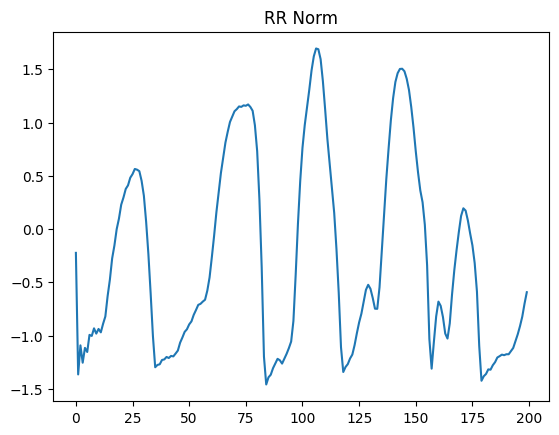

In [17]:
plt.figure(1)
plt.title("RR Norm")
plt.plot(br_downsampled_signal[0][:200],label="RR Wave")

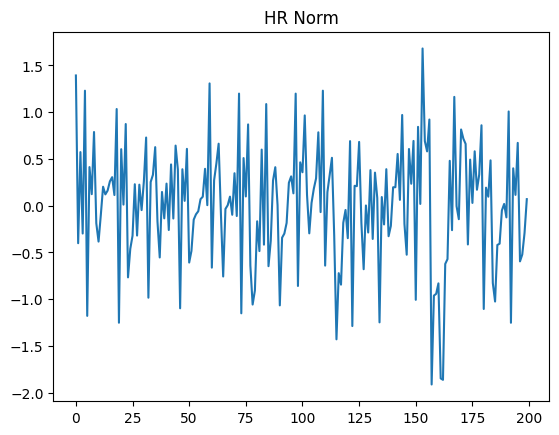

In [18]:
plt.figure(1)
plt.title("HR Norm")
plt.plot(hr_downsampled_signal[0][:200],label="RR Wave")

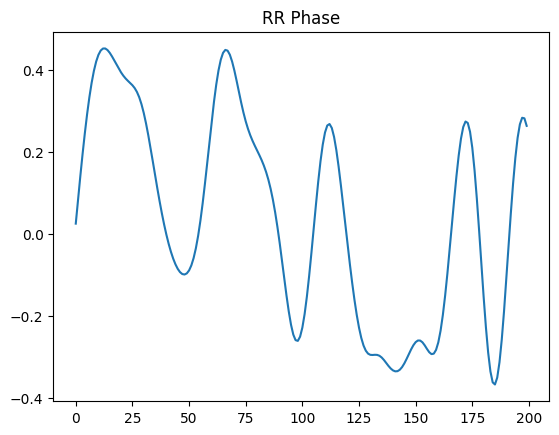

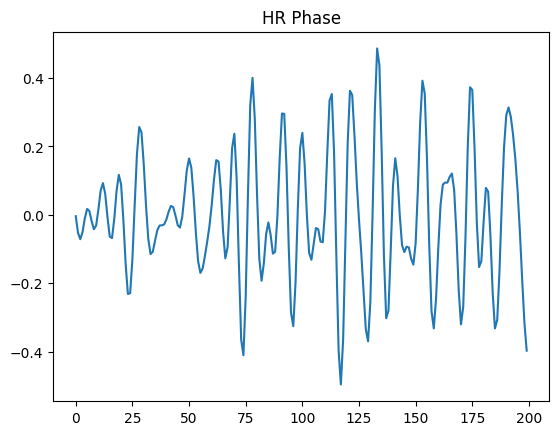

In [19]:
plt.figure(1)
plt.title("RR Phase")
plt.plot(br_phase_array[0][:200],label="RR Phase")
plt.figure(2)
plt.title("HR Phase")
plt.plot(hr_phase_array[0][:200],label="HR Phase")

In [20]:
# Sliding Window 15 Second 
# Sliding Window 
def slid_win(data):
    isi_dataVT =[]
    for k in range(len(data)):
        for i in range(101):
            if i == 0:
                index_1 = i
            else :
                index_1 = index_2 - 380
            index_2 = index_1 + 400
            vt_20s_1 = data[k][index_1:index_2]
        #print(index_1,index_2)
            isi_dataVT.append(vt_20s_1)

    return isi_dataVT

In [21]:
slid_br_phase = np.array(slid_win(br_phase_array))
slid_br_target = np.array(slid_win(br_downsampled_signal))
slid_hr_phase = np.array(slid_win(hr_phase_array))
slid_hr_target = np.array(slid_win(hr_downsampled_signal))

In [22]:
print(slid_br_phase.shape, slid_br_target.shape, slid_hr_phase.shape, slid_hr_target.shape)

(20200, 400) (20200, 400, 1) (20200, 400) (20200, 400, 1)


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1_l2
import keras_tuner

input_shape = (400, 1)  # Input shape dari data radar
output_shape = (400, 1)  # Output shape untuk sinyal detak jantung

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


# def build_model(hp):
#     input_shape = (400, 1)
#     inputs = layers.Input(shape=input_shape)
    
#     conv1 = layers.Conv1D(
#         filters=hp.Int('conv1_filters', 8, 32, step=8),
#         kernel_size=hp.Choice('kernel_size', [5, 10, 20]),
#         activation=hp.Choice('act1', ['relu', 'linear']), 
#         padding='same')(inputs)
#     conv1 = layers.BatchNormalization()(conv1)
#     pool1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
    
#     conv2 = layers.Conv1D(
#         filters=hp.Int('conv2_filters', 16, 64, step=16),
#         kernel_size=hp.Choice('kernel_size', [5, 10, 20]),
#         activation=hp.Choice('act2', ['relu', 'linear']), 
#         padding='same')(pool1)
#     conv2 = layers.BatchNormalization()(conv2)
#     pool2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
    
#     conv3 = layers.Conv1D(
#         filters=hp.Int('conv3_filters', 32, 128, step=32),
#         kernel_size=hp.Choice('kernel_size', [5, 10, 20]),
#         activation=hp.Choice('act3', ['relu', 'linear']), 
#         padding='same')(pool2)
#     conv3 = layers.BatchNormalization()(conv3)
#     pool3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
    
#     conv4 = layers.Conv1D(
#         filters=hp.Int('conv4_filters', 64, 256, step=64),
#         kernel_size=hp.Choice('kernel_size', [5, 10, 20]),
#         activation=hp.Choice('act4', ['relu', 'linear']), 
#         padding='same')(pool3)
#     conv4 = layers.BatchNormalization()(conv4)
#     pool4 = layers.MaxPooling1D(pool_size=2, padding='same')(conv4)
    
#     conv5 = layers.Conv1D(
#         filters=hp.Int('conv5_filters', 128, 512, step=128),
#         kernel_size=hp.Choice('kernel_size', [5, 10, 20]),
#         activation=hp.Choice('act5', ['relu', 'linear']), 
#         padding='same')(pool4)
#     conv5 = layers.BatchNormalization()(conv5)

#     up6 = layers.Conv1DTranspose(filters=hp.Int('conv6T_filters', 64, 256, step=64),
#                                  kernel_size=hp.Choice('kernel_size', [5, 10, 20]),
#                                  strides=2,
#                                  padding='same',
#                                  activation=hp.Choice('act6T', ['relu', 'linear']))(conv5)
#     conv6 = layers.Conv1D(filters=hp.Int('conv6_filters', 64, 256, step=64),
#                           kernel_size=hp.Choice('kernel_size', [5, 10, 20]), 
#                           activation=hp.Choice('act6', ['relu', 'linear']), 
#                           padding='same')(up6)
#     conv6 = layers.BatchNormalization()(conv6)
    
#     up7 = layers.Conv1DTranspose(filters=hp.Int('conv7T_filters', 32, 128, step=32),
#                                  kernel_size=hp.Choice('kernel_size', [5, 10, 20]),
#                                  strides=2,
#                                  padding='same',
#                                  activation=hp.Choice('act7T', ['relu', 'linear']))(conv6)
#     conv7 = layers.Conv1D(filters=hp.Int('conv7_filters', 32, 128, step=32),
#                           kernel_size=hp.Choice('kernel_size', [5, 10, 20]), 
#                           activation=hp.Choice('act7', ['relu', 'linear']), 
#                           padding='same')(up7)
#     conv7 = layers.BatchNormalization()(conv7)

#     up8 = layers.Conv1DTranspose(filters=hp.Int('conv8T_filters', 16, 64, step=16),
#                                  kernel_size=hp.Choice('kernel_size', [5, 10, 20]),
#                                  strides=2,
#                                  padding='same',
#                                  activation=hp.Choice('act8T', ['relu', 'linear']))(conv7)
#     conv8 = layers.Conv1D(filters=hp.Int('conv8_filters', 16, 64, step=16),
#                           kernel_size=hp.Choice('kernel_size', [5, 10, 20]), 
#                           activation=hp.Choice('act8', ['relu', 'linear']), 
#                           padding='same')(up8)
#     conv8 = layers.BatchNormalization()(conv8)
    
#     up9 = layers.Conv1DTranspose(filters=hp.Int('conv9T_filters', 8, 32, step=8),
#                                  kernel_size=hp.Choice('kernel_size', [5, 10, 20]),
#                                  strides=2,
#                                  padding='same',
#                                  activation=hp.Choice('act9T', ['relu', 'linear']))(conv8)
#     conv9 = layers.Conv1D(filters=hp.Int('conv9_filters', 8, 32, step=8),
#                           kernel_size=hp.Choice('kernel_size', [5, 10, 20]), 
#                           activation=hp.Choice('act8', ['relu', 'linear']), 
#                           padding='same')(up9)
#     conv9 = layers.BatchNormalization()(conv9)

#     output = layers.Conv1D(1, 1, activation='linear')(conv9)

#     model = Model(inputs, output)
#     lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
#     model.compile(optimizer=RMSprop(learning_rate=lr), loss='mse') 
#     return model


# tuner = keras_tuner.RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=50,
#     executions_per_trial=1,
#     directory='tuner_results',
#     project_name='tuning_br'
# )

def build_model(hp):
    input_shape = (400, 1)
    inputs = layers.Input(shape=input_shape)
    
    conv1 = layers.Conv1D(
        filters=hp.Int('conv1_filters', 8, 32, step=8),
        kernel_size=hp.Choice('kernel_size', [3, 5, 10]),
        activation=hp.Choice('act1', ['relu', 'linear']), 
        padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
    
    conv2 = layers.Conv1D(
        filters=hp.Int('conv2_filters', 16, 64, step=16),
        kernel_size=hp.Choice('kernel_size', [3, 5, 10]),
        activation=hp.Choice('act2', ['relu', 'linear']), 
        padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
    
    conv3 = layers.Conv1D(
        filters=hp.Int('conv3_filters', 32, 128, step=32),
        kernel_size=hp.Choice('kernel_size', [3, 5, 10]),
        activation=hp.Choice('act3', ['relu', 'linear']), 
        padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
    
    conv4 = layers.Conv1D(
        filters=hp.Int('conv4_filters', 128, 512, step=128),
        kernel_size=hp.Choice('kernel_size', [3, 5, 10]),
        activation=hp.Choice('act4', ['relu', 'linear']), 
        padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    
    up5 = layers.Conv1DTranspose(filters=hp.Int('conv5T_filters', 32, 128, step=32),
                                 kernel_size=hp.Choice('kernel_size', [3, 5, 10]),
                                 strides=2,
                                 padding='same',
                                 activation=hp.Choice('act5T', ['relu', 'linear']))(conv4)
    conv5 = layers.Conv1D(filters=hp.Int('conv5_filters', 32, 128, step=32),
                          kernel_size=hp.Choice('kernel_size', [3, 5, 10]), 
                          activation=hp.Choice('act5', ['relu', 'linear']), 
                          padding='same')(up5)
    conv5 = layers.BatchNormalization()(conv5)

    up6 = layers.Conv1DTranspose(filters=hp.Int('conv6T_filters', 16, 64, step=16),
                                 kernel_size=hp.Choice('kernel_size', [3, 5, 10]),
                                 strides=2,
                                 padding='same',
                                 activation=hp.Choice('act6T', ['relu', 'linear']))(conv5)
    conv6 = layers.Conv1D(filters=hp.Int('conv6_filters', 16, 64, step=16),
                          kernel_size=hp.Choice('kernel_size', [3, 5, 10]), 
                          activation=hp.Choice('act6', ['relu', 'linear']), 
                          padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)
    
    up7 = layers.Conv1DTranspose(filters=hp.Int('conv7T_filters', 8, 32, step=8),
                                 kernel_size=hp.Choice('kernel_size', [3, 5, 10]),
                                 strides=2,
                                 padding='same',
                                 activation=hp.Choice('act7T', ['relu', 'linear']))(conv6)
    conv7 = layers.Conv1D(filters=hp.Int('conv7_filters', 8, 32, step=8),
                          kernel_size=hp.Choice('kernel_size', [3, 5, 10]), 
                          activation=hp.Choice('act7', ['relu', 'linear']), 
                          padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)

    output = layers.Conv1D(1, 1, activation='linear')(conv7)

    model = Model(inputs, output)
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=RMSprop(learning_rate=lr), loss='mse') 
    return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='tuning_br2'
)

Reloading Tuner from tuner_results\tuning_br2\tuner0.json


In [24]:
br_phase_array.shape

(200, 5995)

In [25]:
br_train = slid_br_phase[:16000]
br_test = slid_br_phase[16000:]
br_target_train = slid_br_target[:16000,:,0]
br_target_test = slid_br_target[16000:,:,0]
hr_train = slid_hr_phase[:16000]
hr_test = slid_hr_phase[16000:]
hr_target_train = slid_hr_target[:16000,:,0]
hr_target_test = slid_hr_target[16000:,:,0]

In [26]:
print(br_train.shape)
print(br_test.shape)
print(br_target_train.shape)
print(br_target_test.shape)
print(hr_train.shape)
print(hr_test.shape)
print(hr_target_train.shape)
print(hr_target_test.shape)

(16000, 400)
(4200, 400)
(16000, 400)
(4200, 400)
(16000, 400)
(4200, 400)
(16000, 400)
(4200, 400)


In [46]:
# tuner.search(br_train[:12800], br_target_train[:12800], epochs=30, validation_data=(br_train[:12800], br_target_train[:12800]))
best_model = tuner.get_best_models(num_models=50)[25]
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 400, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 400, 16)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 400, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 200, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 50, 512)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 100, 64)        │       163,904 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 100, 96)        │        30,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 96)        │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 200, 16)        │         7,696 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 200, 48)        │         3,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 200, 48)        │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 400, 32)        │         7,712 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 400, 8)         │         1,288 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 395,761 (1.51 MB)

 Trainable params: 394,209 (1.50 MB)

 Non-trainable params: 1,552 (6.06 KB)

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
# # Training the model
# # Model 6
# # br_history = autoencoder.fit(
# #     br_train,
# #     br_target_train,
# #     epochs=200,
# #     batch_size=32,
# #     validation_split=0.2,
# #     callbacks=[
# #         EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
# #     ]
# # )
# br_history = best_model.fit(
#     br_train,
#     br_target_train,
#     epochs=200,
#     batch_size=32,
#     validation_split=0.2,
#     callbacks=[
#         EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
#     ]
# )

In [47]:
best_model.save("br_model_tuner3.h5")

In [ ]:
# train_loss = br_history.history['loss']
# val_loss = br_history.history['val_loss']

# plt.subplots(1)
# plt.plot(train_loss, color='teal', label='train_loss')
# plt.plot(val_loss, color='orange', label='val_loss')
# plt.legend(loc="upper left")
# plt.title("loss")
# plt.show()

In [39]:
from f_fft_sinyal import fft_sinyal
def calculate_hr_rr(data_rr,data_hr):
    data_rr = np.array(data_rr)
    data_hr = np.array(data_hr)
    freq_rr, fft_rr = fft_sinyal(data_rr)
    freq_hr, fft_hr = fft_sinyal(data_hr)
    peak1 = np.argmax(fft_rr[:20])
    peak2 = np.argmax(fft_hr[:80])
    bpm_rr = freq_rr[peak1]*60
    bpm_hr = freq_hr[peak2]*60
    return bpm_rr, bpm_hr

In [48]:
from tensorflow.keras.models import load_model

br_predict = load_model("br_model_tuner3.h5", custom_objects={'mse': 'mean_squared_error'})
# br_predict.summary()
# hr_predict = load_model("hr_model.h5", custom_objects={'rmse': rmse})



# start = 0
# counter = 0

# An1_RR = br_phase_array[0]
# An2_RR = br_phase_array[1]
# An3_RR = br_phase_array[2]
# An4_RR = br_phase_array[3]
# An1_HR = hr_phase_array[0]
# An2_HR = hr_phase_array[1]
# An3_HR = hr_phase_array[2]
# An4_HR = hr_phase_array[3]
An1_RR = np.array(br_predict(br_test[0].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An2_RR = np.array(br_predict(br_train[1].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An3_RR = np.array(br_predict(br_test[2].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An4_RR = np.array(br_predict(br_test[3].reshape(1, -1, 1).astype(np.float64))[0,:,0])
# An1_HR = np.array(hr_predict(hr_test[0].reshape(1, -1, 1).astype(np.float64))[0,:,0])
# An2_HR = np.array(hr_predict(hr_test[1].reshape(1, -1, 1).astype(np.float64))[0,:,0])
# An3_HR = np.array(hr_predict(hr_test[2].reshape(1, -1, 1).astype(np.float64))[0,:,0])
# An4_HR = np.array(hr_predict(hr_test[3].reshape(1, -1, 1).astype(np.float64))[0,:,0])

# HR_an1 =[]
# HR_an2 =[]
# HR_an3 =[]
# HR_an4 =[]
# RR_an1 =[]
# RR_an2 =[]
# RR_an3 =[]
# RR_an4 =[]

# while counter < 280:  # Changed the loop condition to run for 280 iterations
#         if start + 400 < len(An1_RR):
#             An1_segment_RR = An1_RR[start:start + 400]
#             An2_segment_RR = An2_RR[start:start + 400]
#             An3_segment_RR = An3_RR[start:start + 400]
#             An4_segment_RR = An4_RR[start:start + 400]
#             # HR
#             An1_segment_HR = An1_HR[start:start + 400]
#             An2_segment_HR = An2_HR[start:start + 400]
#             An3_segment_HR = An3_HR[start:start + 400]
#             An4_segment_HR = An4_HR[start:start + 400]

#         else:
#             An1_segment_RR = An1_RR[start:]
#             An2_segment_RR = An2_RR[start:]
#             An3_segment_RR = An3_RR[start:]
#             An4_segment_RR = An4_RR[start:]
#             #HR 
#             An1_segment_HR = An1_HR[start:]
#             An2_segment_HR = An2_HR[start:]
#             An3_segment_HR = An3_HR[start:]
#             An4_segment_HR = An4_HR[start:]
#         # Select The IMF 
#         Rr1,Hr1 = calculate_hr_rr(An1_segment_RR,An1_segment_HR)
#         Rr2,Hr2 = calculate_hr_rr(An2_segment_RR,An2_segment_HR)
#         Rr3,Hr3 = calculate_hr_rr(An3_segment_RR,An3_segment_HR)
#         Rr4,Hr4 = calculate_hr_rr(An4_segment_RR,An4_segment_HR)

#         # rr1,hr1 = calculate_hr_rr(u_rr1, u_hr1)
#         # rr2,hr2 = calculate_hr_rr(u_rr2, u_hr2)
#         # rr3,hr3 = calculate_hr_rr(u_rr3, u_hr3)
#         # rr4,hr4 = calculate_hr_rr(u_rr4, u_hr4) 
       
    
#         # HR_an1.append(hr1)
#         # HR_an2.append(hr2)
#         # HR_an3.append(hr3)
#         # HR_an4.append(hr4)
#         # RR_an1.append(rr1)
#         # RR_an2.append(rr2)
#         # RR_an3.append(rr3)
#         # RR_an4.append(rr4)
#         HR_an1.append(Hr1)
#         HR_an2.append(Hr2)
#         HR_an3.append(Hr3)
#         HR_an4.append(Hr4)
#         RR_an1.append(Rr1)
#         RR_an2.append(Rr2)
#         RR_an3.append(Rr3)
#         RR_an4.append(Rr4)

#         counter += 1
#         start = start + 20

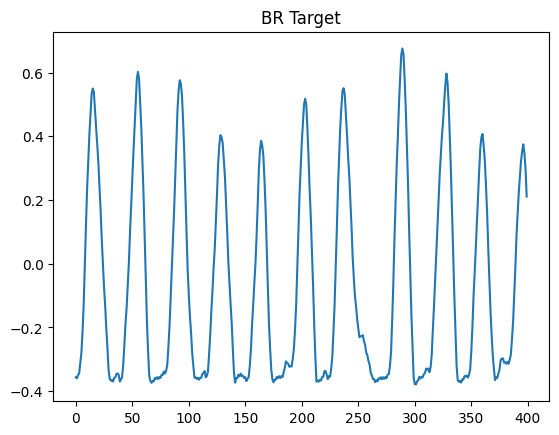

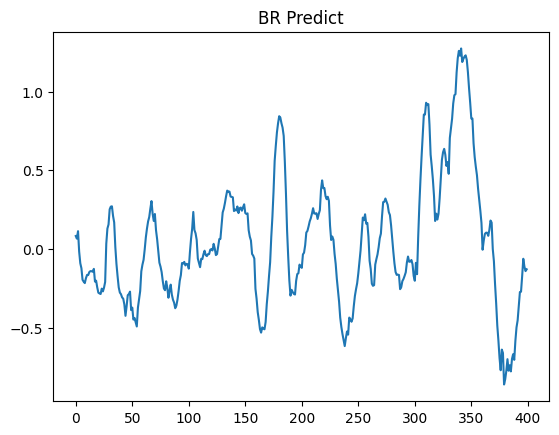

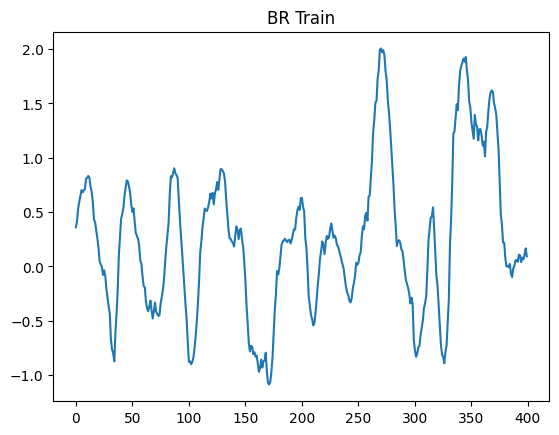

In [49]:
plt.figure(1)
plt.title("BR Target")
plt.plot(br_target_test[0],label="BR Target")
plt.figure(2)
plt.title("BR Predict")
plt.plot(An1_RR,label="BR Predict")
plt.figure(3)
plt.title("BR Train")
plt.plot(An2_RR,label="BR Predict")

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred):
    
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape y_true dan y_pred harus sama")
    
    # Hitung R-squared
    r2 = r2_score(y_true, y_pred)
    
    # Hitung Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    # Hitung Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Hitung Mean Absolute Percentage Error (MAPE)
    # Handle division by zero dengan mengganti 0 dengan nilai sangat kecil
    y_true_adj = np.where(y_true == 0, 1e-10, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100
    
    # Kumpulkan semua hasil dalam dictionary
    metrics = {
        'R-squared': r2,
        'MSE': mse,
        'RMSE': np.sqrt(mse),  # Root Mean Squared Error
        'MAE': mae,
        'MAPE (%)': mape
    }
    
    return metrics

y_true = br_target_test
y_pred = []

for i in range(4200):
    y_pred.append(br_predict(br_test[i].reshape(1, -1, 1).astype(np.float64))[0,:,0])

y_pred = np.array(y_pred)

print(y_true.shape)
print(y_pred.shape)

evaluation_results = evaluate_model(y_true, y_pred)
for metric, value in evaluation_results.items():
    print(f"{metric}: {value:.4f}")

(4200, 400)
(4200, 400)
R-squared: -0.9124
MSE: 0.3897
RMSE: 0.6243
MAE: 0.4111
MAPE (%): 2428782578278781440.0000


In [ ]:
# # Kalman 
# import numpy as np 

# def kalman_filter(z_ppg1):

#     Q=3**2
#     R=100**2
# #     Q=4**2;                    
# #     R=10**2;

#     count=0
#     countmax=5
#     imax=3

#     xposteriori=z_ppg1[0]
#     res = np.zeros(len(z_ppg1))
#     res[0]=z_ppg1[0]
#     Pposteriori=0
#     hasil =[]

#     for i in range (1, len(z_ppg1)):

#         xpriori=xposteriori
#         Ppriori=Pposteriori+Q

#         S=Ppriori+R
#         gain=Ppriori/S

#         inn1=z_ppg1[i]-xpriori

#         if (((count==countmax or i<imax) and ~np.isnan(inn1))):
#             inn=inn1
#             xposteriori=xpriori+gain*inn
#             Pposteriori=(1-gain)*Ppriori
#             if(count==countmax ):
#                 xposteriori=0.5*(z_ppg1[i]+xpriori)
#             count=0

#         else:
#             count=count+1
#             xposteriori=xpriori
#             Pposteriori=Ppriori

#         res[i]=xposteriori
#         hasil.append(xposteriori)

#     return hasil

In [ ]:
# # RR 
# RR_an1 = np.array(RR_an1)
# RR_an2 = np.array(RR_an2)
# RR_an3 = np.array(RR_an3)
# RR_an4 = np.array(RR_an4)
# TOTAL_RR = (RR_an1+RR_an2+RR_an3+RR_an4)/4 
# Kalman_rr = kalman_filter(TOTAL_RR)
# RR_ref = br[21:261]
# plt.plot(Kalman_rr[:240],label ="RR-Radar")
# plt.plot(RR_ref, label="Reference")
# plt.xlabel("Time (s)")
# plt.ylabel("BPM")
# plt.legend()

In [ ]:
# # RR 
# HR_an1 = np.array(HR_an1)
# HR_an2 = np.array(HR_an2)
# HR_an3 = np.array(HR_an3)
# HR_an4 = np.array(HR_an4)
# TOTAL_HR = (HR_an1+HR_an2+HR_an3+HR_an4)/4 
# Kalman_Hr = kalman_filter(TOTAL_HR)
# HR_ref = hr[21:261]
# plt.plot(Kalman_Hr[:240],label ="HR-Radar")
# plt.plot(HR_ref, label="Reference")
# plt.xlabel("Time (s)")
# plt.ylabel("BPM")
# plt.legend()